In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from shutil import copy2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels

# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

## 1. loading the data 
We first load our Cifar10 dataset and visualize its shapes

In [2]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
print("Shape for train image set:", x_train.shape)
print("Shape for train labels:" ,y_train.shape)
print("Shape for test image set:", x_test.shape)
print("Shape for test label:" ,y_test.shape)

Shape for train image set: (50000, 32, 32, 3)
Shape for train labels: (50000, 1)
Shape for test image set: (10000, 32, 32, 3)
Shape for test label: (10000, 1)


## 2. Some preprocessing to put our images and labels in the right shape

In [3]:
# Image normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows,img_cols,n_channels=x_train.shape[1:]
num_classes=10
# Now we one hot encode outputs
y_train = to_categorical(y_train, num_classes)
y_test1 = to_categorical(y_test, num_classes)

In [4]:
y_test1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## 3. Model architecture design
Our model architecture is consists of:

a) 4 Conv-pooling layers for feature selection followed by 1 dense layer and 1 softmax layer for classification

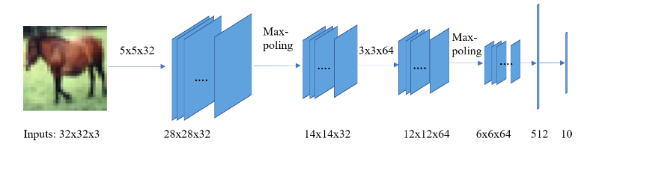

b)Activation functions: ReLU

c)Batch normalization

d)Use SoftMax layer for classification

e)Number of epochs: 100 and

f)Batch-size is 32

g)Optimizer:SGD with a learning rate and momentum.

In [5]:
model = Sequential()
# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (5, 5),input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(512))

model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters


# Let's create our model
model.compile(loss = 'categorical_crossentropy',
              optimizer =SGD(learning_rate=0.01,momentum=0.9),
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        2

### Model training

In [6]:
import time
checkpoint = ModelCheckpoint("Cifar10_V2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]


epochs = 100
batch_size=32
time_start=time.perf_counter()
history= model.fit(x=x_train,y=y_train,
    epochs = epochs,
    callbacks = callbacks,
    batch_size=batch_size,
    validation_data = (x_test,y_test1))
elapsed_time=time.perf_counter()-time_start

Epoch 1/100
1563/1563 [==============================] - ETA: 0s - loss: 1.6437 - accuracy: 0.4091
Epoch 00001: val_loss improved from inf to 1.44024, saving model to Cifar10_V2.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6437 - accuracy: 0.4091 - val_loss: 1.4402 - val_accuracy: 0.4873 - lr: 0.0100
Epoch 2/100
1559/1563 [============================>.] - ETA: 0s - loss: 1.2740 - accuracy: 0.5458
Epoch 00002: val_loss improved from 1.44024 to 1.32388, saving model to Cifar10_V2.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2737 - accuracy: 0.5459 - val_loss: 1.3239 - val_accuracy: 0.5316 - lr: 0.0100
Epoch 3/100
1554/1563 [============================>.] - ETA: 0s - loss: 1.0999 - accuracy: 0.6126
Epoch 00003: val_loss improved from 1.32388 to 1.21739, saving model to Cifar10_V2.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0993 - accuracy: 0.6128 - val_loss: 1.2174 - val_accuracy: 0.5887 - lr: 0.0100
Epoch 4/100

1559/1563 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8706
Epoch 00026: val_loss did not improve from 0.65150
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3657 - accuracy: 0.8706 - val_loss: 0.6529 - val_accuracy: 0.7841 - lr: 8.0000e-05
Epoch 27/100
1555/1563 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8727
Epoch 00027: val_loss did not improve from 0.65150

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3681 - accuracy: 0.8727 - val_loss: 0.6536 - val_accuracy: 0.7839 - lr: 8.0000e-05
Epoch 28/100
1555/1563 [============================>.] - ETA: 0s - loss: 0.3647 - accuracy: 0.8719
Epoch 00028: val_loss did not improve from 0.65150
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3646 - accuracy: 0.8720 - val_loss: 0.6532 - val_accuracy: 0.7836 - lr: 1.6000e-05
Epoch 29/100
1558/1563 [=====

1562/1563 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8694
Epoch 00051: val_loss did not improve from 0.65150

Epoch 00051: ReduceLROnPlateau reducing learning rate to 4.095999650566285e-11.
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3694 - accuracy: 0.8693 - val_loss: 0.6520 - val_accuracy: 0.7837 - lr: 2.0480e-10
Epoch 52/100
1556/1563 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8711
Epoch 00052: val_loss did not improve from 0.65150
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3650 - accuracy: 0.8710 - val_loss: 0.6522 - val_accuracy: 0.7836 - lr: 4.0960e-11
Epoch 53/100
1561/1563 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8719
Epoch 00053: val_loss did not improve from 0.65150
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3661 - accuracy: 0.8719 - val_loss: 0.6529 - val_accuracy: 0.7834 - lr: 4.0960e-11
Epoch 54/100
1552/1563 [=====

Epoch 76/100
1560/1563 [============================>.] - ETA: 0s - loss: 0.3690 - accuracy: 0.8700
Epoch 00076: val_loss did not improve from 0.65150
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3688 - accuracy: 0.8702 - val_loss: 0.6522 - val_accuracy: 0.7833 - lr: 1.0486e-16
Epoch 77/100
1554/1563 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8702
Epoch 00077: val_loss did not improve from 0.65150
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3677 - accuracy: 0.8702 - val_loss: 0.6525 - val_accuracy: 0.7837 - lr: 1.0486e-16
Epoch 78/100
1557/1563 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8704
Epoch 00078: val_loss did not improve from 0.65150

Epoch 00078: ReduceLROnPlateau reducing learning rate to 2.0971519334479774e-17.
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3664 - accuracy: 0.8704 - val_loss: 0.6517 - val_accuracy: 0.7833 - lr: 1.0486e-16
Epoch 79/100
15

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


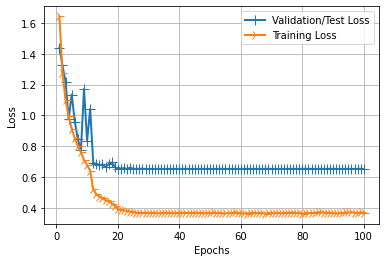

In [7]:
print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss.png', dpi = 1200)
plt.show()

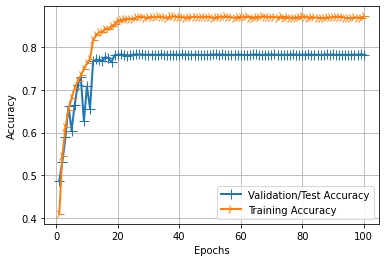

In [8]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy.png', dpi = 1200)
plt.show()

### Evaluation

In [9]:
y_pred=np.argmax(model.predict(x_test), axis=1)
y_test=np.concatenate(y_test)

In [10]:
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [11]:
accuracy=accuracy_score(y_test,y_pred)
class_report=classification_report(y_test,y_pred)
print("Model accuracy:",accuracy)
print("Classification report\n:",class_report)

Model accuracy: 0.7831
Classification report
:               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.90      0.87      0.89      1000
           2       0.73      0.66      0.69      1000
           3       0.60      0.60      0.60      1000
           4       0.75      0.76      0.75      1000
           5       0.67      0.69      0.68      1000
           6       0.81      0.86      0.84      1000
           7       0.85      0.82      0.84      1000
           8       0.86      0.89      0.87      1000
           9       0.85      0.85      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [12]:
elapsed_time

640.6844151089899

### Confusion Matrix


 Classification report: 
               precision    recall  f1-score   support

   airplance       0.80      0.82      0.81      1000
  automobile       0.90      0.87      0.89      1000
        bird       0.73      0.66      0.69      1000
         cat       0.60      0.60      0.60      1000
        deer       0.75      0.76      0.75      1000
         dog       0.67      0.69      0.68      1000
        frog       0.81      0.86      0.84      1000
       horse       0.85      0.82      0.84      1000
        ship       0.86      0.89      0.87      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



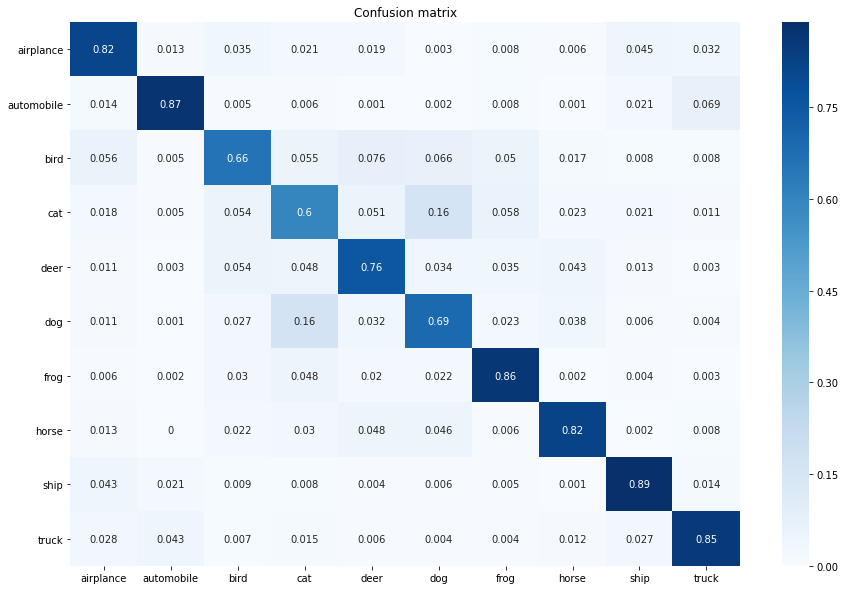

In [13]:
import seaborn as sr
import pandas as pd
# y_predict,distances1=  face_recognition(x_test_recog,T_distance)
# accuracy=accuracy_score(y_test_recog,y_predict)
class_names=["airplance","automobile","bird","cat","deer","dog","frog","horse",'ship',"truck"]
report=classification_report(y_test,y_pred,target_names=class_names)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
plt.title("Confusion matrix")
plt.show()

In [14]:
print(class_names)

['airplance', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
